<img src="https://github.com/superannotateai/automation-suites/blob/main/docs/sa_logo.png?raw=1" width="250" align="left">

#  ASR with Whisper

This tutorial walks you through the ```Automatic Speech Recognition``` automation pipeline within SuperAnnotate platform. 

In this tutorial we will go through the following steps:

1. Setup the environment and install dependences
2. Run the ```OpenAI Whisper``` model on ```US Election 2020 - Presidential Debates``` dataset
3. Setup a ```Video``` project at SuperAnnotate with the dataset audio files (currently audio files are treated basically as videos without visual content, so they are hosted in the ```Video``` editor, we will release a separate ```Audio``` editor very soon, so stay tuned!!!
4. Upload the transcribed text with Whisper as a freetext attribute to SuperAnnotate platform
5. Results visualized in the platform



## 1.  Environment Setup

Please hit the ```RESTART RUNTIME``` button in the installation logs below, or if it is not there manually navigate Runtime -> Restart Runtime

In [ ]:
! pip install superannotate==4.4.7 #SA SDK installation
! pip install git+https://github.com/openai/whisper.git #install OpenAI Whisper


# 1.1  User Variables Setup

SuperAnnotate Python SDK functions work within the team scope of the platform, so a team-level authorization is required. To authorize the package in a given team scope, get the authorization token from the team settings page.

In [ ]:
SDK_TOKEN = "ADD_YOUR_TOKEN_HERE" #Your SuperAnnotate SDK token
PROJECT_NAME = "ADD_YOUR_PROJECT_NAME_HERE" #A project with this name will be created to upload all voice files and transcribtions

#1.2 Constants Setup

In [ ]:
S3_BASE_URL = "https://sa-public-datasets.s3.amazonaws.com/audio-datasets/us-elections-2020-debates/"
DATASET_FILES = [
    "us_election_2020_1st_presidential_debate.mp3",
    "us_election_2020_2nd_presidential_debate.mp3",
    "us_election_2020_biden_town_hall.mp3",
    "us_election_2020_trump_town_hall.mp3",
    "us_election_2020_vice_presidential_debate.mp3"
]

#1.3 Download the data

In [ ]:
from os.path import join
import requests
import os

os.makedirs('data', exist_ok=True)
for dataset_file in DATASET_FILES:
  response = requests.get(join(S3_BASE_URL, dataset_file))
  with open(join('data', dataset_file), 'wb') as f:
    f.write(response.content)

## 2. Model Prediction

In [ ]:
import whisper

model = whisper.load_model('tiny')
transcribtions = {}
for dataset_file in DATASET_FILES:
  result = model.transcribe(join('data', dataset_file))
  transcribtions[dataset_file] = result["text"]

## 3. Project Setup

# 3.1 Authorize SA SDK


In [ ]:
from superannotate import SAClient

sa = SAClient(token=SDK_TOKEN)

#3.2 Create the project and attach the dataset

In [ ]:
# 1. create a Video project
sa.create_project(PROJECT_NAME, "2020 US presidential elections debates' audio transcription with OpenAI Whisper", "Video")

# 2. create dataset CSV to attach to the platform
import pandas as pd

data = {
    "name": DATASET_FILES,
    "url": [join(S3_BASE_URL, dataset_file) for dataset_file in DATASET_FILES]
}
df = pd.DataFrame(data)
df.to_csv('data.csv')

# 3. attach dataset
sa.attach_items(PROJECT_NAME, "./data.csv")

## 4. Import Predictions

#4.1 Construct the annotation dictionaries

In [ ]:
annotations = []
for file_name, transcribtion in transcribtions.items():
  sa_format = {
      "metadata": {
          "name": file_name
      },
      "instances": [],
      "tags": [transcribtion],
      "comments": []
  }
  annotations.append(sa_format)

#4.2 Upload the transcribtions to the platform

In [ ]:
sa.upload_annotations(PROJECT_NAME, annotations)

#5 Locating the results in the platform

After finishing all these steps you can navigate to the [SuperAnnotate Platform](https://app.superannotate.com), login choose your team (to which the SDK_TOKEN in this tutorial belongs). There a new project with PROJECT_NAME should be created. When opening any of the audio files in that project you will see the editor display as seen below: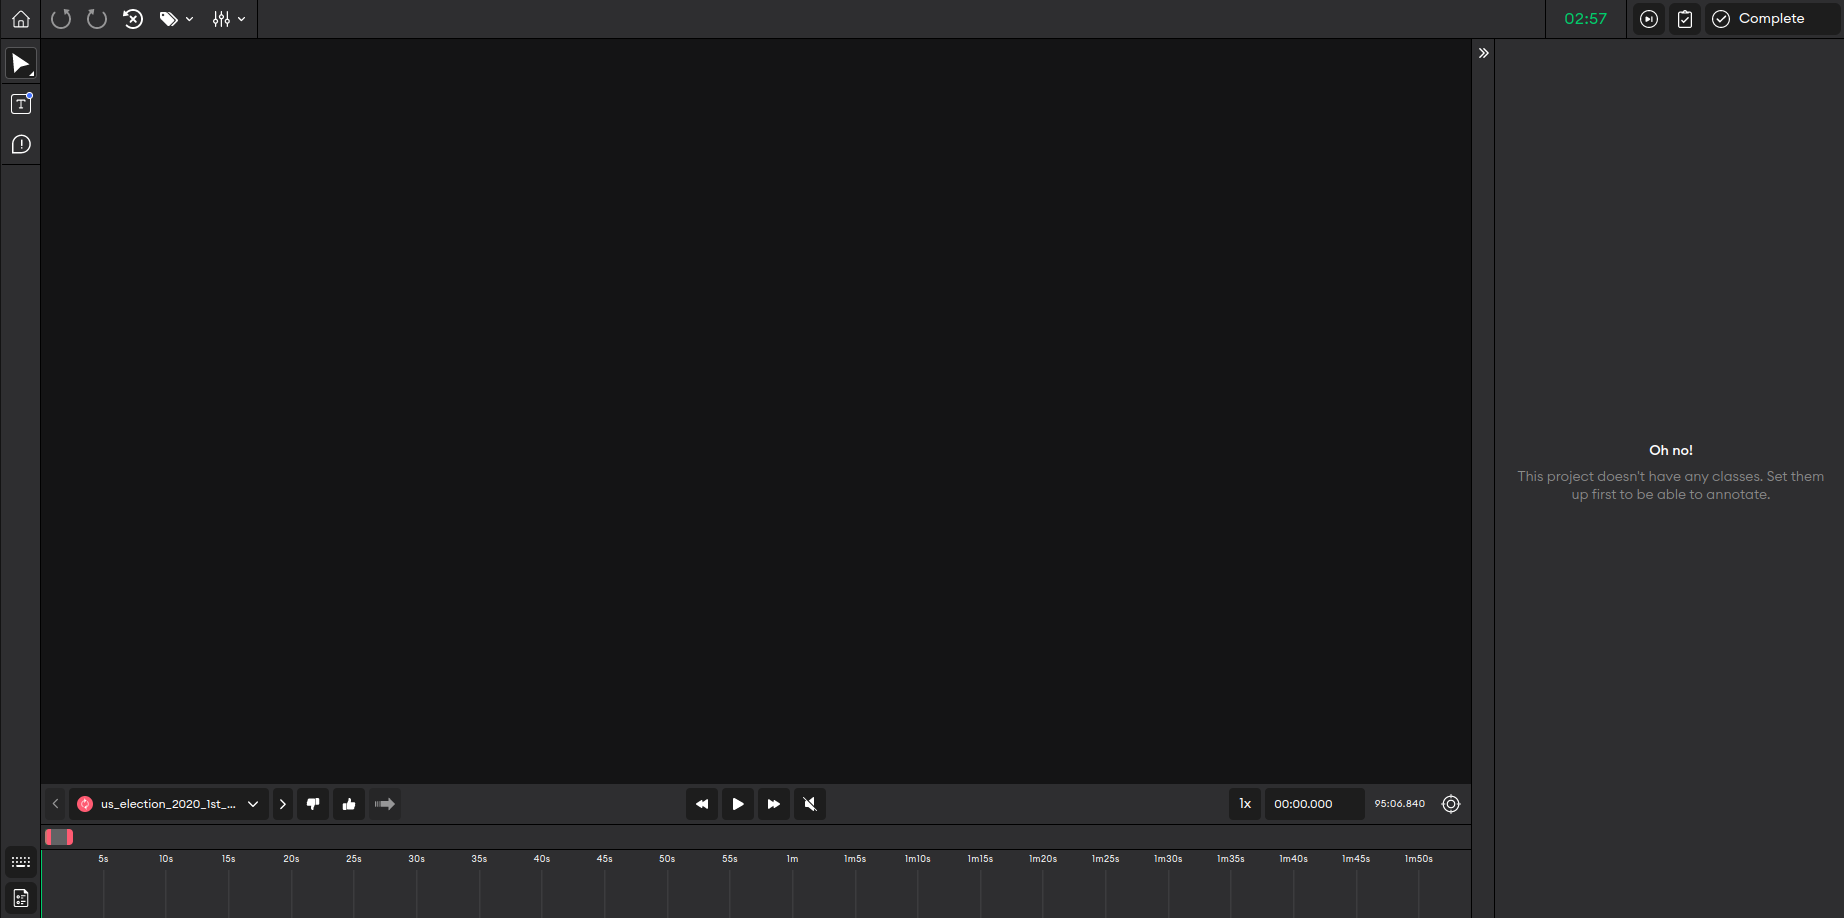
By clicking the ```T in the box``` icon on the left panel, the transcription to the audio will appear, and your screen will look like this: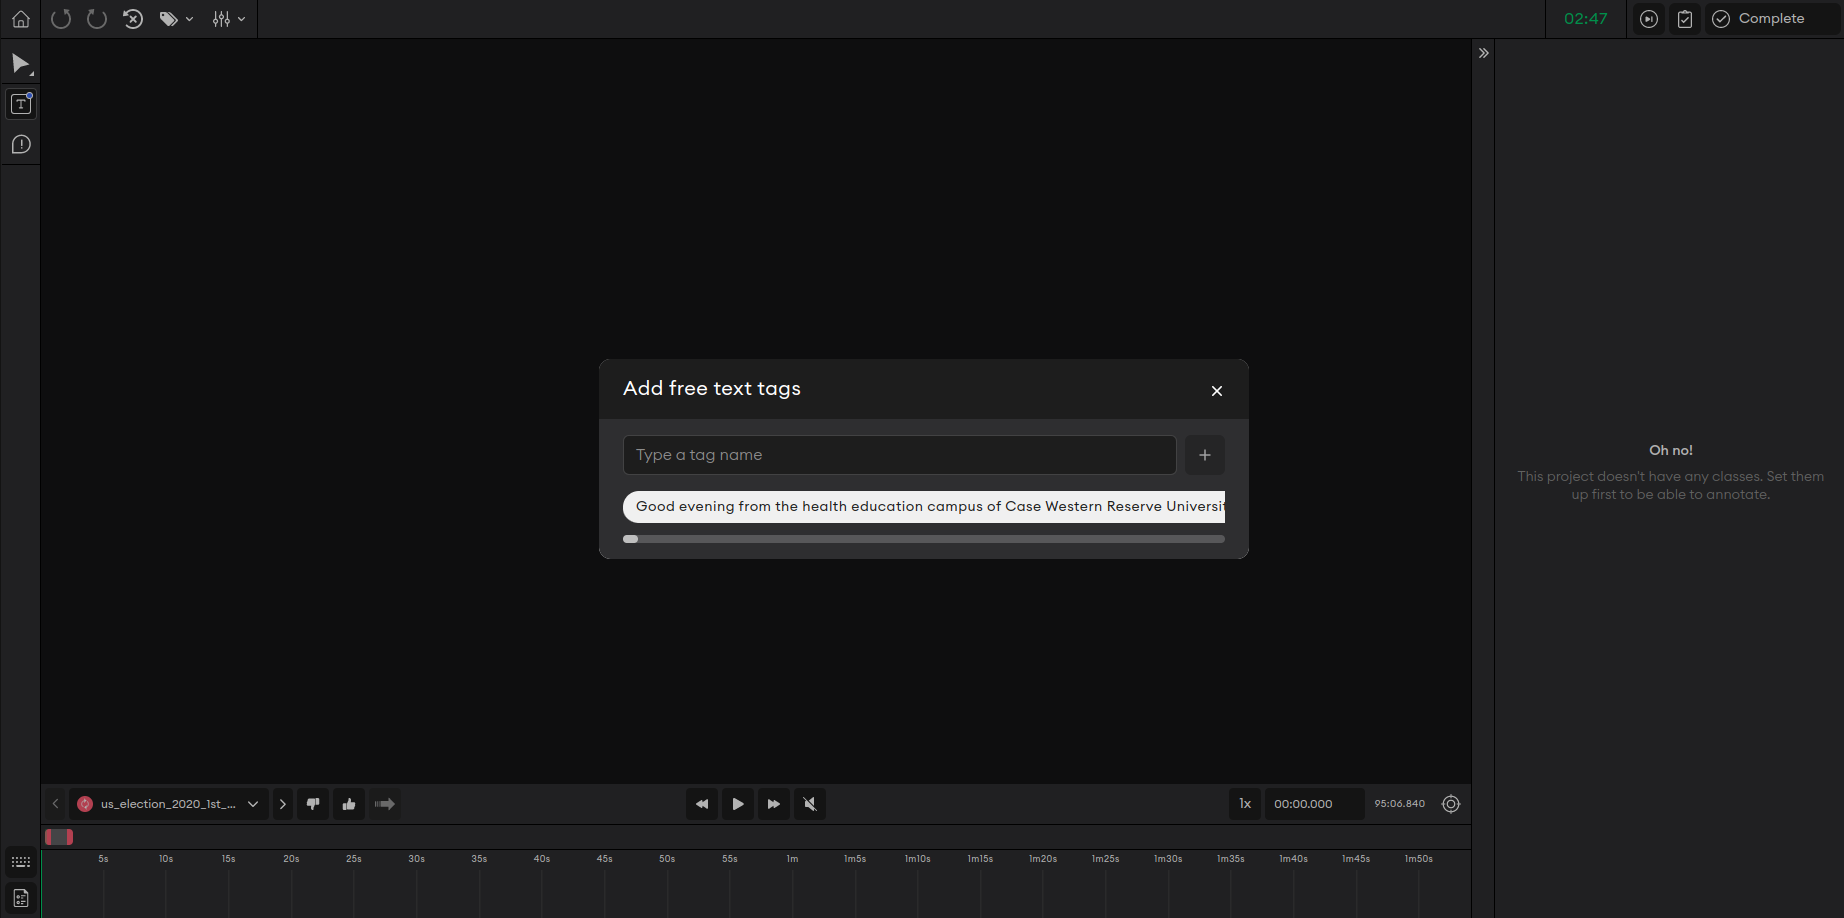